# Convolution Image Net

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
from utils.nn_graph import simple_layer
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Conv Net Graph

In [4]:
from utils.nn_visualization import conv33132_summaries, conv55124_summary, variable_summaries

In [5]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('conv_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')
        is_training = tf.placeholder(tf.bool, name='is_training')
            
    with tf.name_scope('image_reshape'):        
        images_reshaped = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv_layer_1'):
        w_conv_1 = tf.get_variable('w_conv_1', [3, 3, 1, 32], initializer=tf.contrib.layers.variance_scaling_initializer())
        b_conv_1 = tf.get_variable('b_conv_1', initializer=tf.constant_initializer(0), shape=[32])
        conv33132_summaries('w_conv_1_summary', w_conv_1)

        conv_layer_1 = tf.nn.conv2d(images_reshaped, w_conv_1, strides=[1, 1, 1, 1], padding='SAME')
        # conv_layer_1 = tf.contrib.layers.batch_norm(conv_layer_1, is_training=is_training)
        conv_layer_1 = conv_layer_1 + b_conv_1
        conv_layer_1 = tf.nn.relu(conv_layer_1)
        conv_layer_1 = tf.nn.max_pool(conv_layer_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')   

    with tf.variable_scope('conv_layer_2'):
        w_conv_2 = tf.get_variable('w_conv_2', [3, 3, 32, 64], initializer=tf.contrib.layers.variance_scaling_initializer())
        b_conv_2 = tf.get_variable('b_conv_2', initializer=tf.constant_initializer(0), shape=[64])
  
        conv_layer_2 = tf.nn.conv2d(conv_layer_1, w_conv_2, strides=[1, 1, 1, 1], padding='SAME')
        # conv_layer_2 = tf.contrib.layers.batch_norm(conv_layer_2, is_training=is_training)
        conv_layer_2 = conv_layer_2 + b_conv_2
        conv_layer_2 = tf.nn.relu(conv_layer_2)
        conv_layer_2 = tf.nn.max_pool(conv_layer_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    with tf.variable_scope('feed_forward_layer_1'):
        ff_layer_1 = tf.reshape(conv_layer_2, [-1, 7*7*64])
        ff_layer_1 = simple_layer('ff_1', ff_layer_1, shape=[7*7*64, 10], activation='linear')
        raw_prediction = tf.nn.dropout(ff_layer_1, keep_dropout_prob)
    
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.variable_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)

    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=raw_prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)
        
    with tf.name_scope('training'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_step  = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)
    
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [6]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/conv_image_net/'
exp_name = 'experiment_1'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Add Embedding Projection

In [7]:
from utils.nn_visualization import init_embedding_projector, init_embedding_data
from utils.nn_visualization import get_sprite_img, get_label_class_names

sprite_img = get_sprite_img(data.validation.images, img_shape)
label_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)

init_embedding_data(logging_meta['valid_writer_dir'], sprite_img, label_names)
init_embedding_projector(logging_meta['valid_writer'], embedding, img_shape)

## Run Conv Net

In [9]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']

validation_feed_dict = {
    images: data.validation.images, 
    labels: data.validation.labels,
    keep_dropout_prob: 1., 
    is_training: False}

with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(5000):
        ##################
        # Training phase #
        ##################
        _images, _labels = data.train.next_batch(100)
        feed_dict = {images: _images, labels: _labels, keep_dropout_prob: 0.5, is_training: True}
        _ = session.run([train_step], feed_dict=feed_dict)
        if iteration % 10 == 0:
            feed_dict={images: _images, labels: _labels, keep_dropout_prob: 1., is_training: False}
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss],feed_dict=feed_dict)
            logging_meta['train_writer'].add_summary(_summary, iteration)
            print("Train Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
      
        ####################
        # Validation phase #
        ####################
        if iteration % 100 == 0:
            fetches = [embedding_assignment, merge_summaries, accuracy, loss]
            _, _summary, _accuracy, _loss = session.run(fetches, validation_feed_dict)
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("= Valid Iteration {}: loss {}, accuracy {} =".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict=validation_feed_dict)

Train Iteration 0: loss 2.6019606590270996, accuracy 0.11999999731779099
= Valid Iteration 0: loss 2.570827007293701, accuracy 0.12759999930858612 =
Train Iteration 10: loss 2.1854329109191895, accuracy 0.20999999344348907
Train Iteration 20: loss 1.951827049255371, accuracy 0.38999998569488525
Train Iteration 30: loss 1.7890527248382568, accuracy 0.44999998807907104
Train Iteration 40: loss 1.6841603517532349, accuracy 0.5299999713897705
Train Iteration 50: loss 1.5630778074264526, accuracy 0.5899999737739563
Train Iteration 60: loss 1.469772219657898, accuracy 0.6200000047683716
Train Iteration 70: loss 1.4311578273773193, accuracy 0.6200000047683716
Train Iteration 80: loss 1.3540383577346802, accuracy 0.7099999785423279
Train Iteration 90: loss 1.226658821105957, accuracy 0.6899999976158142
Train Iteration 100: loss 1.157884955406189, accuracy 0.699999988079071
= Valid Iteration 100: loss 1.2158929109573364, accuracy 0.6772000193595886 =
Train Iteration 110: loss 1.0662754774093628

= Valid Iteration 1000: loss 0.5229489207267761, accuracy 0.8605999946594238 =
Train Iteration 1010: loss 0.48446741700172424, accuracy 0.8899999856948853
Train Iteration 1020: loss 0.5647380352020264, accuracy 0.8199999928474426
Train Iteration 1030: loss 0.489053338766098, accuracy 0.8700000047683716
Train Iteration 1040: loss 0.6918885707855225, accuracy 0.800000011920929
Train Iteration 1050: loss 0.544526994228363, accuracy 0.8600000143051147
Train Iteration 1060: loss 0.47042959928512573, accuracy 0.8999999761581421
Train Iteration 1070: loss 0.45289984345436096, accuracy 0.8500000238418579
Train Iteration 1080: loss 0.5382140874862671, accuracy 0.8899999856948853
Train Iteration 1090: loss 0.5395271182060242, accuracy 0.8399999737739563
Train Iteration 1100: loss 0.43900179862976074, accuracy 0.9100000262260437
= Valid Iteration 1100: loss 0.5041812062263489, accuracy 0.8650000095367432 =
Train Iteration 1110: loss 0.5925866961479187, accuracy 0.8100000023841858
Train Iteration 

Train Iteration 2000: loss 0.45224204659461975, accuracy 0.8199999928474426
= Valid Iteration 2000: loss 0.4330962002277374, accuracy 0.878600001335144 =
Train Iteration 2010: loss 0.5535318851470947, accuracy 0.8399999737739563
Train Iteration 2020: loss 0.5178307890892029, accuracy 0.8199999928474426
Train Iteration 2030: loss 0.3814806640148163, accuracy 0.8999999761581421
Train Iteration 2040: loss 0.46637532114982605, accuracy 0.8500000238418579
Train Iteration 2050: loss 0.4334251284599304, accuracy 0.8899999856948853
Train Iteration 2060: loss 0.4703972637653351, accuracy 0.8999999761581421
Train Iteration 2070: loss 0.4586809575557709, accuracy 0.8600000143051147
Train Iteration 2080: loss 0.5578615069389343, accuracy 0.8100000023841858
Train Iteration 2090: loss 0.4915267825126648, accuracy 0.8299999833106995
Train Iteration 2100: loss 0.427760511636734, accuracy 0.8899999856948853
= Valid Iteration 2100: loss 0.42736807465553284, accuracy 0.8791999816894531 =
Train Iteration 

Train Iteration 2990: loss 0.26500821113586426, accuracy 0.949999988079071
Train Iteration 3000: loss 0.3402859568595886, accuracy 0.949999988079071
= Valid Iteration 3000: loss 0.3945552408695221, accuracy 0.8871999979019165 =
Train Iteration 3010: loss 0.4214462339878082, accuracy 0.8600000143051147
Train Iteration 3020: loss 0.34168294072151184, accuracy 0.8799999952316284
Train Iteration 3030: loss 0.49056586623191833, accuracy 0.800000011920929
Train Iteration 3040: loss 0.334224134683609, accuracy 0.8999999761581421
Train Iteration 3050: loss 0.43967223167419434, accuracy 0.8899999856948853
Train Iteration 3060: loss 0.40356189012527466, accuracy 0.9100000262260437
Train Iteration 3070: loss 0.41411739587783813, accuracy 0.8600000143051147
Train Iteration 3080: loss 0.3764435946941376, accuracy 0.8799999952316284
Train Iteration 3090: loss 0.35328206419944763, accuracy 0.9100000262260437
Train Iteration 3100: loss 0.4009121358394623, accuracy 0.8899999856948853
= Valid Iteration 

Train Iteration 3980: loss 0.3637288808822632, accuracy 0.9100000262260437
Train Iteration 3990: loss 0.3543280065059662, accuracy 0.8799999952316284
Train Iteration 4000: loss 0.3151600956916809, accuracy 0.8999999761581421
= Valid Iteration 4000: loss 0.3744502067565918, accuracy 0.8881999850273132 =
Train Iteration 4010: loss 0.449018657207489, accuracy 0.8899999856948853
Train Iteration 4020: loss 0.48382633924484253, accuracy 0.800000011920929
Train Iteration 4030: loss 0.3313935101032257, accuracy 0.9100000262260437
Train Iteration 4040: loss 0.365062415599823, accuracy 0.9200000166893005
Train Iteration 4050: loss 0.3801470696926117, accuracy 0.8799999952316284
Train Iteration 4060: loss 0.2707369923591614, accuracy 0.949999988079071
Train Iteration 4070: loss 0.3719465136528015, accuracy 0.8700000047683716
Train Iteration 4080: loss 0.3556581735610962, accuracy 0.9100000262260437
Train Iteration 4090: loss 0.3356367349624634, accuracy 0.9100000262260437
Train Iteration 4100: lo

Train Iteration 4970: loss 0.44703200459480286, accuracy 0.8399999737739563
Train Iteration 4980: loss 0.33385008573532104, accuracy 0.8999999761581421
Train Iteration 4990: loss 0.29249516129493713, accuracy 0.9100000262260437


## Results evaluation

In [10]:
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_accuracy
from utils.results_evaluation import get_false_positives
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_rec_prec
from utils.results_evaluation import plot_coocurance_matrix
from utils.results_evaluation import plot_examples 

In [11]:
df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, data.validation.images)

In [12]:
get_accuracy(df)

89.14

In [13]:
get_accuracy(df, True)

98.68

In [14]:
get_rec_prec(df, class_id2class_name_mapping)

,class_name,precision,recall
0,T-shirt/top,72.79,91.90
1,Trouser,98.72,97.30
2,Pullover,83.74,81.75
3,Dress,85.79,92.81
4,Coat,80.43,84.22
5,Sandal,95.14,99.19
6,Shirt,81.79,55.58
7,Sneaker,96.84,95.90
8,Bag,97.91,95.71
9,Ankle boot,97.98,95.85


In [15]:
fp = get_false_positives(df, 'Shirt')

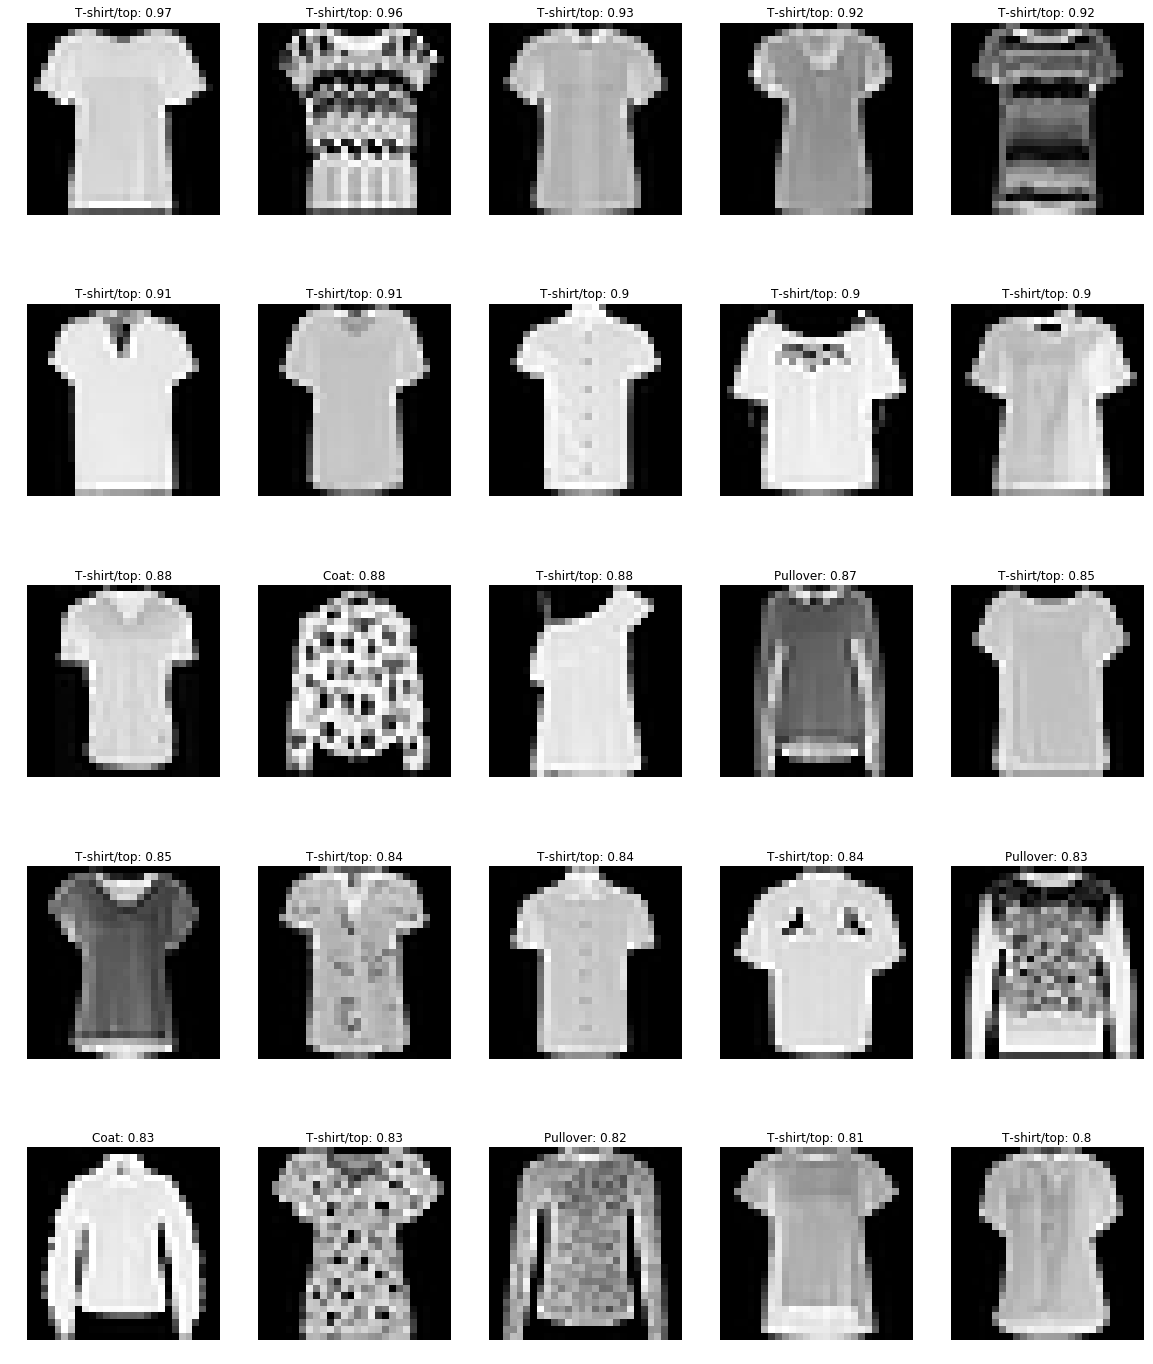

In [16]:
plot_examples(fp)

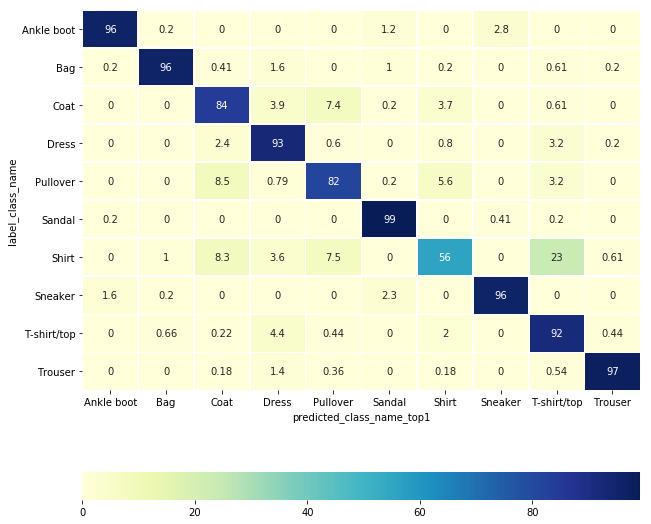

In [17]:
plot_coocurance_matrix(df, use_top3=False, use_log=False)